In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Inflation

In [2]:
data = pd.read_csv('data/estat_prc_hicp_manr_filtered_en.csv')

In [3]:
data.columns
df = data[['geo', 'TIME_PERIOD', 'OBS_VALUE']]
df.loc[:,'TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], format='%Y-%m')

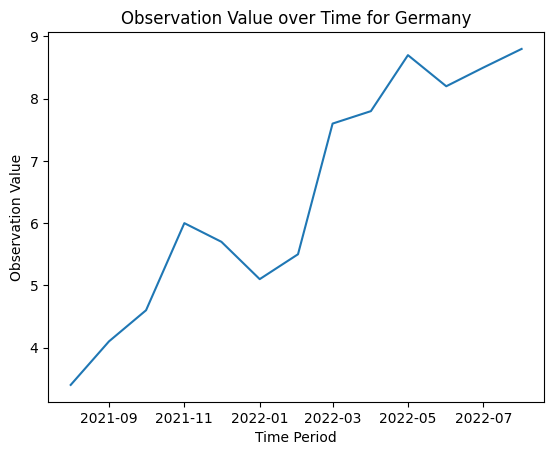

In [4]:
country = 'Germany'

plt.plot(df[df['geo'] == country]['TIME_PERIOD'], df[df['geo'] == country]['OBS_VALUE'])
plt.xlabel('Time Period')
plt.ylabel('Observation Value')
plt.title(f'Observation Value over Time for {country}')
plt.show()

/home/jeanluca/.pyenv/versions/lewagon/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


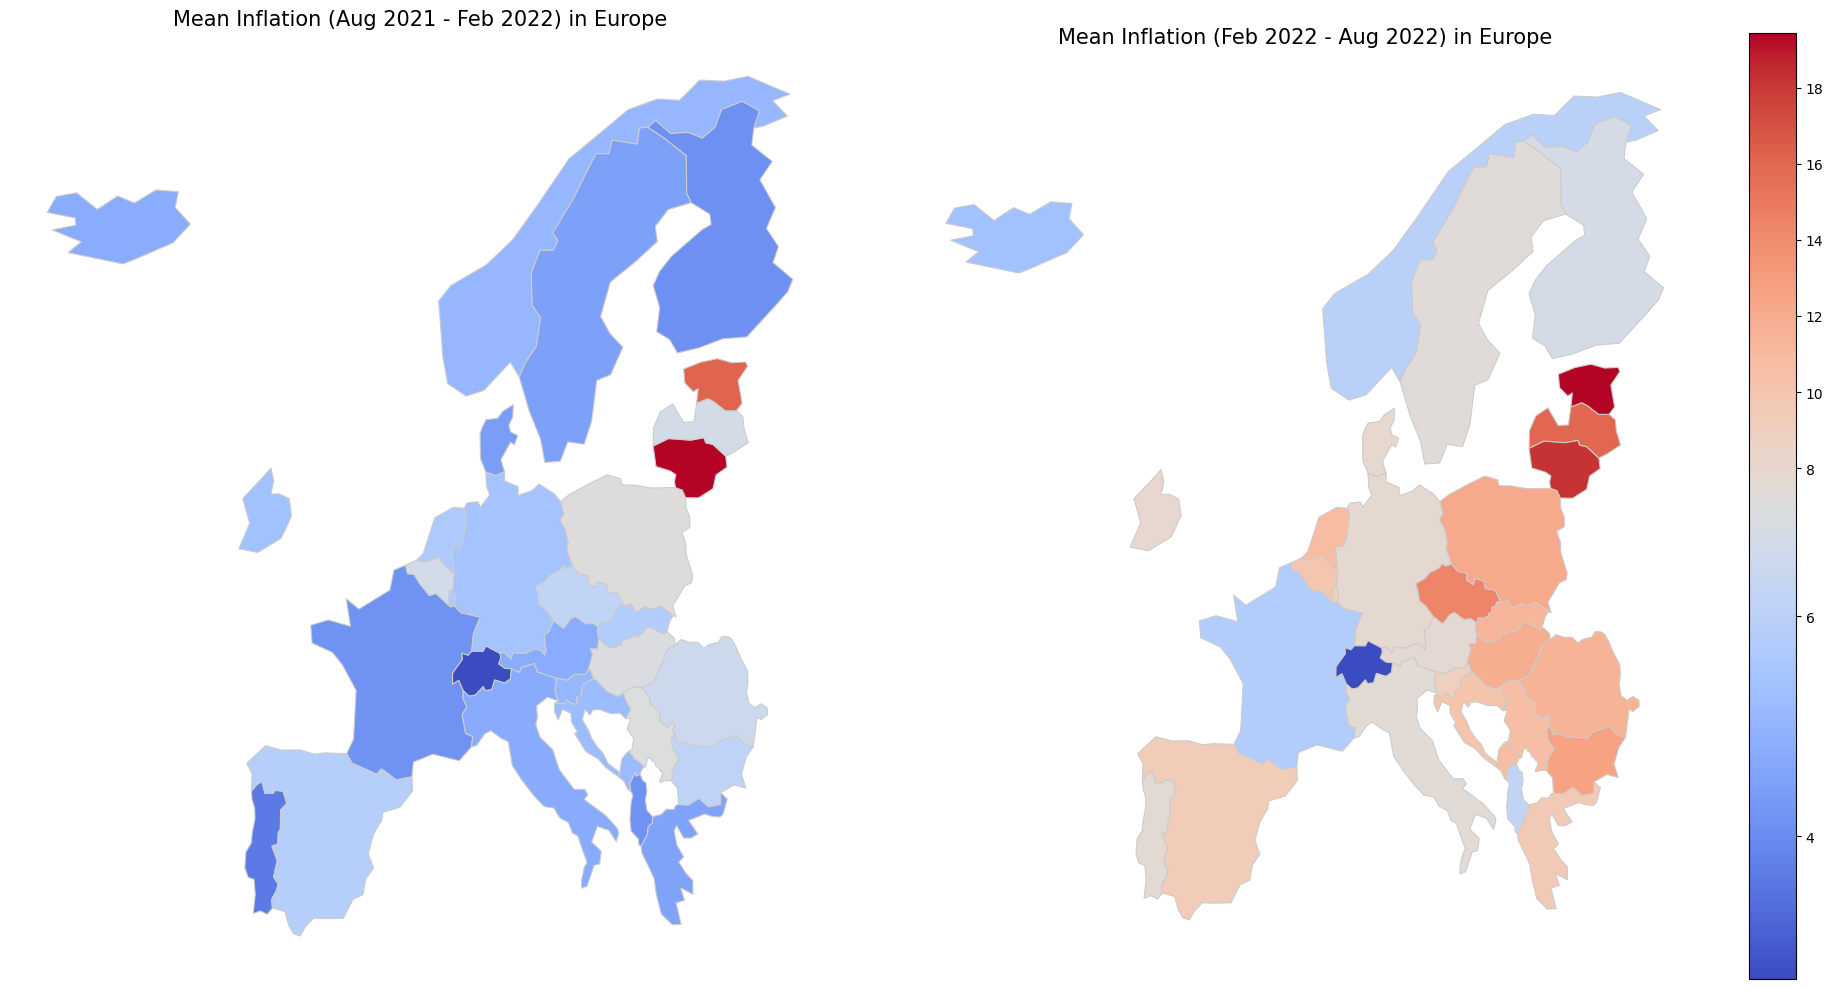

In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from shapely.geometry import MultiPolygon

# Assume your DataFrame is named df and make a copy to work on
data = df.copy()

# Convert TIME_PERIOD to datetime
data['TIME_PERIOD'] = pd.to_datetime(data['TIME_PERIOD'])

# Load world map and filter for European countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']

# Remove small islands (like the Azores) by keeping only the largest polygon in each multipolygon
def keep_largest(geom):
    if geom.type == 'MultiPolygon':
        return max(geom.geoms, key=lambda a: a.area)
    else:
        return geom

europe['geometry'] = europe['geometry'].apply(keep_largest)

# ---------------------------
# Period 1: Aug 2021 - Feb 2022
# ---------------------------
mask1 = (data['TIME_PERIOD'] >= pd.to_datetime('2021-08-01')) & (data['TIME_PERIOD'] <= pd.to_datetime('2022-02-01'))
data_filtered1 = data.loc[mask1]

# Group by country and compute the mean inflation for period 1
inflation_by_country1 = data_filtered1.groupby('geo')['OBS_VALUE'].mean().reset_index()
inflation_by_country1.rename(columns={'OBS_VALUE': 'mean_inflation'}, inplace=True)

# Merge with European geodataframe (ensure country names match)
europe_inflation1 = europe.merge(inflation_by_country1, left_on='name', right_on='geo', how='left')

# Create normalization centered at 7
vmin1 = europe_inflation1['mean_inflation'].min()
vmax1 = europe_inflation1['mean_inflation'].max()
norm1 = TwoSlopeNorm(vmin=vmin1, vcenter=7, vmax=vmax1)

# ---------------------------
# Period 2: Feb 2022 - Aug 2022
# ---------------------------
mask2 = (data['TIME_PERIOD'] >= pd.to_datetime('2022-02-01')) & (data['TIME_PERIOD'] <= pd.to_datetime('2022-08-01'))
data_filtered2 = data.loc[mask2]

# Group by country and compute the mean inflation for period 2
inflation_by_country2 = data_filtered2.groupby('geo')['OBS_VALUE'].mean().reset_index()
inflation_by_country2.rename(columns={'OBS_VALUE': 'mean_inflation'}, inplace=True)

# Merge with European geodataframe
europe_inflation2 = europe.merge(inflation_by_country2, left_on='name', right_on='geo', how='left')

# Create normalization centered at 7 for period 2
vmin2 = europe_inflation2['mean_inflation'].min()
vmax2 = europe_inflation2['mean_inflation'].max()
norm2 = TwoSlopeNorm(vmin=vmin2, vcenter=7, vmax=vmax2)

# ---------------------------
# Plot side by side
# ---------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot Period 1 without legend
europe_inflation1.plot(column='mean_inflation', cmap='coolwarm', linewidth=0.8,
                       ax=ax1, edgecolor='0.8', legend=False, norm=norm1)
ax1.set_title('Mean Inflation (Aug 2021 - Feb 2022) in Europe', fontsize=15)
ax1.axis('off')

# Plot Period 2 with legend
europe_inflation2.plot(column='mean_inflation', cmap='coolwarm', linewidth=0.8,
                       ax=ax2, edgecolor='0.8', legend=True, norm=norm2)
ax2.set_title('Mean Inflation (Feb 2022 - Aug 2022) in Europe', fontsize=15)
ax2.axis('off')

plt.tight_layout()
plt.show()


In [6]:
selected_countries = ["Germany",
"France",
"Netherlands",
"Italy",
"Spain",
"Estonia",
"Latvia",
"Lithuania",
"Poland",
"Finland",
"Sweden",
"Denmark",
"Greece",
"Portugal",
"Cyprus",
"United Kingdom",
"Austria",
"Czechia",
"Hungary",
"Slovakia",
"Bulgaria",
"Croatia",
"Romania",
"Slovenia",
"Serbia"]

In [ ]:
# Sort the DataFrame by country and time
df_sorted = df.sort_values(['geo', 'TIME_PERIOD'])
# df_sorted = df_sorted[~df_sorted['geo'].isin(selected_countries)]
df_sorted = df_sorted[df_sorted['geo'].isin(selected_countries)]

# Group by country and compute the first and last inflation values
diff_df = df_sorted.groupby('geo').agg(
    first_inflation=('OBS_VALUE', 'first'),
    last_inflation=('OBS_VALUE', 'last')
).reset_index()

# Compute the inflation change for each country
diff_df['inflation_change'] = diff_df['last_inflation'] - diff_df['first_inflation']

# Count how many countries have an increase in inflation (change > 0)
num_countries_increase = (diff_df['inflation_change'] > 0).sum()

print("Number of countries with an increase in inflation:", num_countries_increase)
print("Number of countries in dataset:", len(df_sorted.geo.unique()))
diff_df.sort_values(by=['inflation_change'], ascending=False)

Number of countries with an increase in inflation: 24
Number of countries in dataset: 24


,geo,first_inflation,last_inflation,inflation_change
6,Estonia,5.0,25.2,20.2
13,Latvia,3.6,21.4,17.8
14,Lithuania,5.0,21.1,16.1
4,Czechia,3.1,17.1,14.0
11,Hungary,4.9,18.6,13.7
1,Bulgaria,2.5,15.0,12.5
15,Netherlands,2.7,13.7,11.0
20,Slovakia,3.3,13.4,10.1
10,Greece,1.2,11.2,10.0
16,Poland,5.0,14.8,9.8


# Subsidies

In [20]:
sub_data = pd.read_csv('data/estat_gov_10a_exp_filtered_en.csv')

In [31]:
df_sub = sub_data[['geo', 'TIME_PERIOD', 'OBS_VALUE']]
df_sub.loc[:,'TIME_PERIOD'] = pd.to_datetime(df_sub['TIME_PERIOD'], format='%Y')

/home/jeanluca/.pyenv/versions/lewagon/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


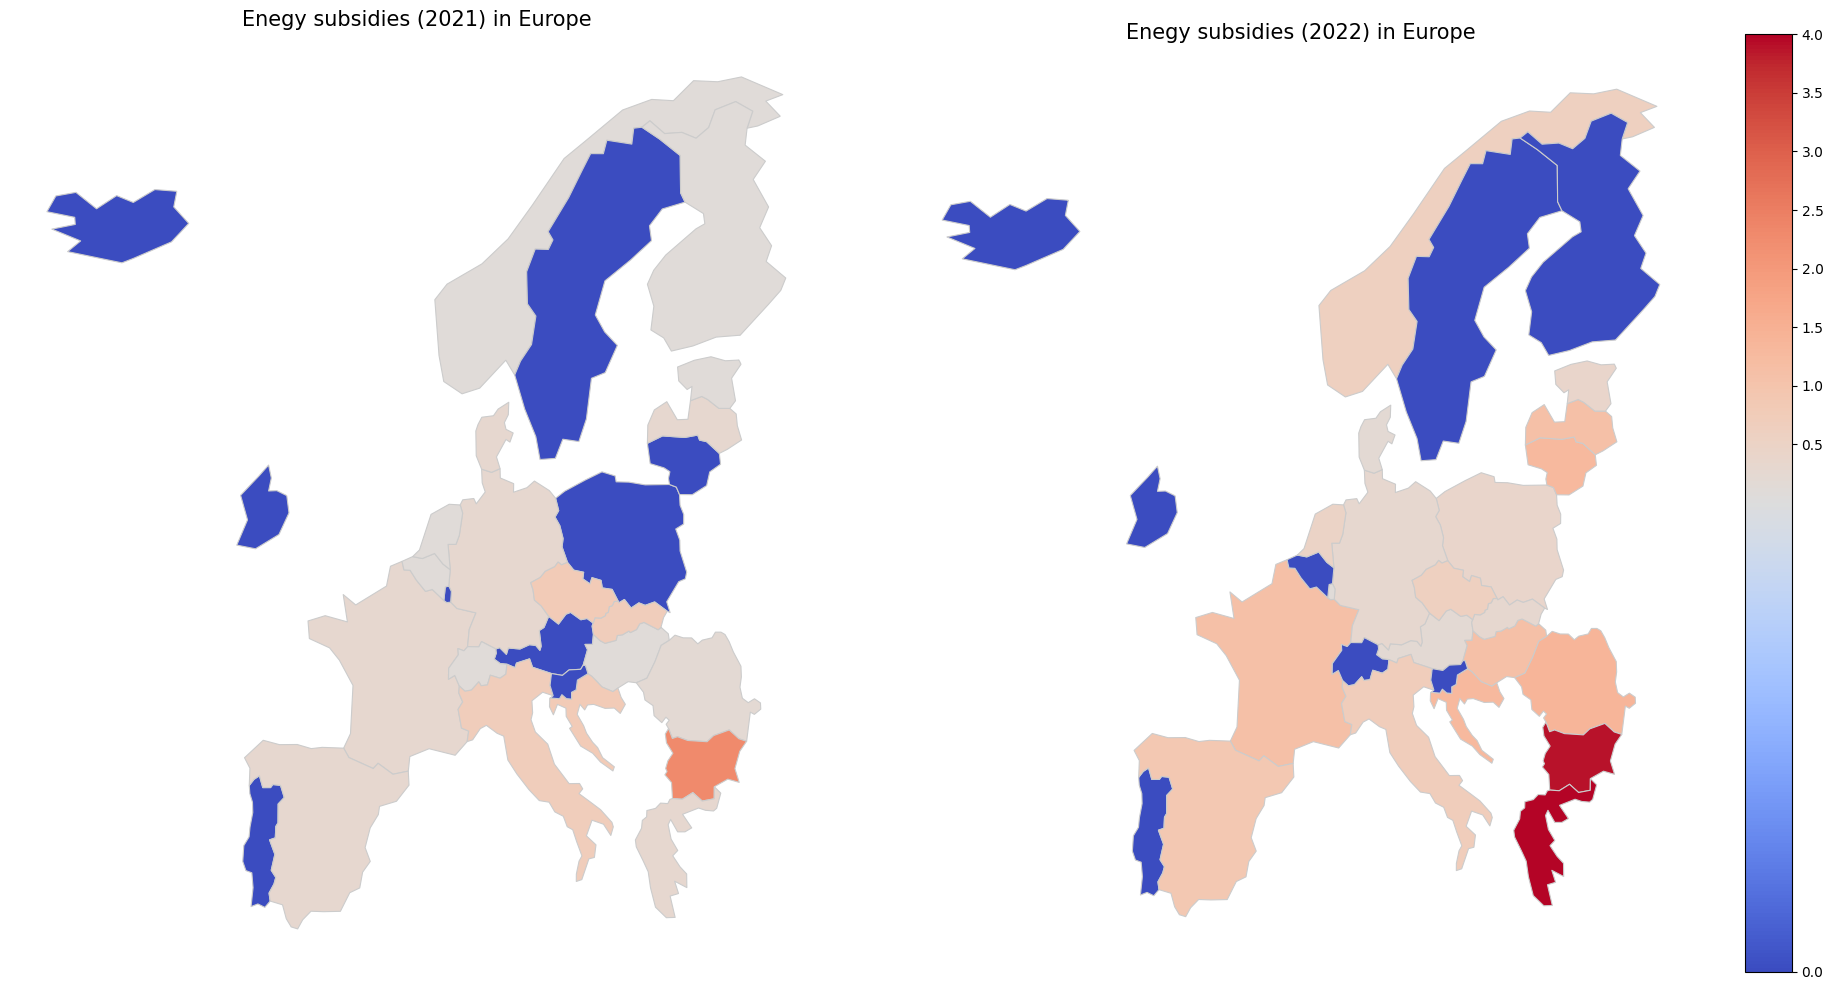

In [50]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Assume your DataFrame is named df and make a copy to work on
data = df_sub.copy()

# Load world map and filter for European countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']

# Remove small islands (like the Azores) by keeping only the largest polygon in each multipolygon
def keep_largest(geom):
    if geom.type == 'MultiPolygon':
        return max(geom.geoms, key=lambda a: a.area)
    else:
        return geom

europe['geometry'] = europe['geometry'].apply(keep_largest)

# ---------------------------
# Period 1: Aug 2021 - Feb 2022
# ---------------------------
mask1 = (data['TIME_PERIOD'] == pd.to_datetime('2021-01'))
data_filtered1 = data.loc[mask1]

# Group by country and compute the mean inflation for period 1
inflation_by_country1 = data_filtered1.groupby('geo')['OBS_VALUE'].mean().reset_index()
inflation_by_country1.rename(columns={'OBS_VALUE': 'mean_inflation'}, inplace=True)

# Merge with European geodataframe (ensure country names match)
europe_inflation1 = europe.merge(inflation_by_country1, left_on='name', right_on='geo', how='left')

# ---------------------------
# Period 2: Feb 2022 - Aug 2022
# ---------------------------
mask2 = (data['TIME_PERIOD'] == pd.to_datetime('2022-01'))
data_filtered2 = data.loc[mask2]

# Group by country and compute the mean inflation for period 2
inflation_by_country2 = data_filtered2.groupby('geo')['OBS_VALUE'].mean().reset_index()
inflation_by_country2.rename(columns={'OBS_VALUE': 'mean_inflation'}, inplace=True)

# Merge with European geodataframe
europe_inflation2 = europe.merge(inflation_by_country2, left_on='name', right_on='geo', how='left')

# Determine the overall minimum and maximum inflation values across both periods
global_min = min(europe_inflation1['mean_inflation'].min(), europe_inflation2['mean_inflation'].min())
global_max = max(europe_inflation1['mean_inflation'].max(), europe_inflation2['mean_inflation'].max())

# Create a normalization object
norm = TwoSlopeNorm(vmin=global_min, vcenter=0.0000000000001, vmax=global_max)

# ---------------------------
# Plot side by side
# ---------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot Period 1 without legend
europe_inflation1.plot(column='mean_inflation', cmap='coolwarm', norm=norm, linewidth=0.8,
                       ax=ax1, edgecolor='0.8', legend=False)
ax1.set_title('Enegy subsidies (2021) in Europe', fontsize=15)
ax1.axis('off')

# Plot Period 2 with legend
europe_inflation2.plot(column='mean_inflation', cmap='coolwarm', norm=norm, linewidth=0.8,
                       ax=ax2, edgecolor='0.8', legend=True)
ax2.set_title('Enegy subsidies (2022) in Europe', fontsize=15)
ax2.axis('off')

plt.tight_layout()
plt.show()


In [46]:
# Sort the DataFrame by country and time
df_sorted = data.sort_values(['geo', 'TIME_PERIOD'])
# df_sorted = df_sorted[~df_sorted['geo'].isin(selected_countries)]
df_sorted = df_sorted[df_sorted['geo'].isin(selected_countries)]

# Group by country and compute the first and last inflation values
diff_df = df_sorted.groupby('geo').agg(
    first_sub=('OBS_VALUE', 'first'),
    last_sub=('OBS_VALUE', 'last')
).reset_index()

# Compute the inflation change for each country
diff_df['subsidy_change'] = diff_df['last_sub'] - diff_df['first_sub']

# Count how many countries have an increase in inflation (change > 0)
num_countries_increase = (diff_df['subsidy_change'] > 0).sum()

print("Number of countries with an increase in sub:", num_countries_increase)
print("Number of countries in dataset:", len(df_sorted.geo.unique()))
diff_df.sort_values(by=['subsidy_change'], ascending=False)

Number of countries with an increase in sub: 14
Number of countries in dataset: 23


,geo,first_sub,last_sub,subsidy_change
10,Greece,0.3,4.0,3.7
1,Bulgaria,2.3,3.9,1.6
14,Lithuania,0.0,1.3,1.3
18,Romania,0.2,1.4,1.2
11,Hungary,0.1,1.1,1.0
13,Latvia,0.3,1.1,0.8
8,France,0.3,1.1,0.8
21,Spain,0.3,0.9,0.6
2,Croatia,0.8,1.3,0.5
16,Poland,0.0,0.4,0.4
